In [173]:
import hoomd
import gsd
import gsd.hoomd

# set integrator
# dt = set step size
integrator = hoomd.md.Integrator(dt=0.005)

# set interparticle potential as LJ
cell = hoomd.md.nlist.Cell(buffer=0.2)
lj = hoomd.md.pair.LJ(nlist=cell)
lj.params[('A', 'A')] = dict(epsilon=1, sigma=1)
lj.r_cut[('A', 'A')] = 3
integrator.forces.append(lj)


In [174]:
import numpy as np
import fresnel


# NVT runs for equilibration
nvt = hoomd.md.methods.ConstantVolume(
    filter=hoomd.filter.All(), thermostat=hoomd.md.methods.thermostats.Bussi(kT=2.48)
)
integrator.methods.append(nvt)

# set initial conditions--generate particle in a KxKxK 3D box

m = 5 # m = number of unit cell in each axis
N_lattices = m**2 #number of lattices in 2d
N_particles = 2*N_lattices # since we assume 2 particles per unit cell for FCC in 2D
a = 1.8 #lattice constant
L = m*a
epsilon = a/2 # to avoid placing atoms on edges
# Create 1D arrays of the lattice positions for x and y
x = np.linspace(-L/2, L/2, m, endpoint=False)
y = np.linspace(-L/2, L/2, m, endpoint=False)

# Use broadcasting to create a grid of positions (atom 1 in each unit cell)
X, Y = np.meshgrid(x, y)
positions = np.column_stack((X.ravel(), Y.ravel(), np.zeros(N_lattices)))

# Add the second atom in each unit cell (shifted by a/2 in x and y)
shifted_positions = positions + np.array([a/2, a/2, 0])

# Combine both sets of positions
positions = np.vstack((positions, shifted_positions))

frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = positions[0:N_particles]
frame.particles.typeid = [0] * N_particles
frame.configuration.box = [L+epsilon, L+epsilon, 0, 0, 0, 0]


# add name for this particle type
frame.particles.types = ['A']

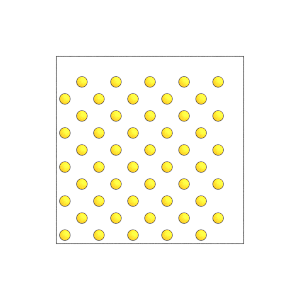

In [175]:
import importlib
import render_2D
importlib.reload(render_2D)
device = fresnel.Device()
render = render_2D.render(frame, device, 300, 300)
render.get_image()

In [176]:
with gsd.hoomd.open(name='lattice.gsd', mode='a') as f:
    f.append(frame)
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=1)
simulation.create_state_from_gsd(filename='lattice.gsd')

In [177]:
simulation.operations.integrator = integrator
simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=2.48) # room temperature

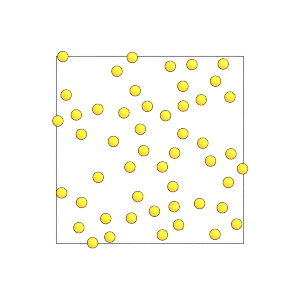

In [178]:
simulation.run(10000)
render = render_2D.render(simulation.state.get_snapshot(), device, 300, 300)
render.get_image()

In [179]:
rho = simulation.state.N_particles / simulation.state.box.volume
print(rho)

0.5101520646182001


In [180]:
final_rho = 1.1
final_volume = simulation.state.N_particles / final_rho
inverse_volume_ramp = hoomd.variant.box.InverseVolumeRamp(
    initial_box=simulation.state.box,
    final_volume=final_volume,
    t_start=simulation.timestep,
    t_ramp=20_000,
)
box_resize = hoomd.update.BoxResize(
    trigger=hoomd.trigger.Periodic(10),
    box=inverse_volume_ramp,
)
simulation.operations.updaters.append(box_resize)
simulation.run(20001)

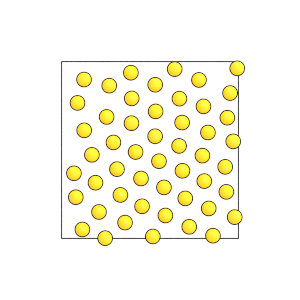

In [181]:
render = render_2D.render(simulation.state.get_snapshot(), device, 300, 300)
render.get_image()